In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import cv2

In [13]:
# 创建数据集文件夹
dataset_dir = Path('./dataset')
hr_dir = dataset_dir / 'high_resolution'
lr_dir = dataset_dir / 'low_resolution'

hr_dir.mkdir(parents=True, exist_ok=True)
lr_dir.mkdir(parents=True, exist_ok=True)

print(f"数据集目录已创建: {dataset_dir}")

数据集目录已创建: dataset


In [14]:
# 参数设置
HR_SIZE = 256  # 高分辨率图片大小
LR_SIZE = 64   # 低分辨率图片大小
NUM_SAMPLES = 1000  # 生成样本数量
SCALE_FACTOR = HR_SIZE // LR_SIZE  # 缩放倍数

In [15]:
def generate_circle(size=256):
    """生成圆形"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    center = (size // 2, size // 2)
    radius = np.random.randint(size // 6, size // 3)
    color = tuple(np.random.randint(100, 255, 3).tolist())
    thickness = -1  # 填充
    cv2.circle(img, center, radius, color, thickness)
    return img

def generate_rectangle(size=256):
    """生成矩形"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    w = np.random.randint(size // 4, size // 2)
    h = np.random.randint(size // 4, size // 2)
    x = np.random.randint(size // 6, size - w - size // 6)
    y = np.random.randint(size // 6, size - h - size // 6)
    color = tuple(np.random.randint(100, 255, 3).tolist())
    cv2.rectangle(img, (x, y), (x + w, y + h), color, -1)
    return img

def generate_triangle(size=256):
    """生成三角形"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    pts = np.array([
        [size // 2, size // 4],
        [size // 4, 3 * size // 4],
        [3 * size // 4, 3 * size // 4]
    ], np.int32)
    # 添加随机偏移
    offset = np.random.randint(-size // 8, size // 8, pts.shape)
    pts = pts + offset
    pts = pts.reshape((-1, 1, 2))
    color = tuple(np.random.randint(100, 255, 3).tolist())
    cv2.fillPoly(img, [pts], color)
    return img

def generate_ellipse(size=256):
    """生成椭圆"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    center = (size // 2, size // 2)
    axes = (np.random.randint(size // 6, size // 3), 
            np.random.randint(size // 8, size // 4))
    angle = np.random.randint(0, 180)
    color = tuple(np.random.randint(100, 255, 3).tolist())
    cv2.ellipse(img, center, axes, angle, 0, 360, color, -1)
    return img

def generate_polygon(size=256):
    """生成多边形"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    num_points = np.random.randint(5, 8)
    center = np.array([size // 2, size // 2])
    radius = np.random.randint(size // 4, size // 3)
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    pts = np.array([
        center + radius * np.array([np.cos(a), np.sin(a)]) 
        for a in angles
    ], np.int32)
    pts = pts.reshape((-1, 1, 2))
    color = tuple(np.random.randint(100, 255, 3).tolist())
    cv2.fillPoly(img, [pts], color)
    return img

def generate_multi_shapes(size=256):
    """生成多个形状的组合"""
    img = np.zeros((size, size, 3), dtype=np.uint8)
    num_shapes = np.random.randint(2, 4)
    
    for _ in range(num_shapes):
        shape_type = np.random.choice(['circle', 'rectangle', 'triangle'])
        if shape_type == 'circle':
            center = (np.random.randint(size // 4, 3 * size // 4), 
                     np.random.randint(size // 4, 3 * size // 4))
            radius = np.random.randint(size // 12, size // 6)
            color = tuple(np.random.randint(50, 255, 3).tolist())
            cv2.circle(img, center, radius, color, -1)
        elif shape_type == 'rectangle':
            w = np.random.randint(size // 8, size // 4)
            h = np.random.randint(size // 8, size // 4)
            x = np.random.randint(size // 8, size - w - size // 8)
            y = np.random.randint(size // 8, size - h - size // 8)
            color = tuple(np.random.randint(50, 255, 3).tolist())
            cv2.rectangle(img, (x, y), (x + w, y + h), color, -1)
        else:
            cx = np.random.randint(size // 4, 3 * size // 4)
            cy = np.random.randint(size // 4, 3 * size // 4)
            s = np.random.randint(size // 12, size // 6)
            pts = np.array([[cx, cy - s], [cx - s, cy + s], [cx + s, cy + s]], np.int32)
            pts = pts.reshape((-1, 1, 2))
            color = tuple(np.random.randint(50, 255, 3).tolist())
            cv2.fillPoly(img, [pts], color)
    
    return img

In [16]:
def downscale_image(img, scale_factor=4, method='bicubic'):
    """降低图片分辨率
    
    Args:
        img: 输入图片
        scale_factor: 缩放倍数
        method: 降采样方法 ('bicubic', 'bilinear', 'area')
    """
    h, w = img.shape[:2]
    new_h, new_w = h // scale_factor, w // scale_factor
    
    if method == 'bicubic':
        interpolation = cv2.INTER_CUBIC
    elif method == 'bilinear':
        interpolation = cv2.INTER_LINEAR
    elif method == 'area':
        interpolation = cv2.INTER_AREA
    else:
        interpolation = cv2.INTER_CUBIC
    
    lr_img = cv2.resize(img, (new_w, new_h), interpolation=interpolation)
    return lr_img

In [17]:
# 生成数据集
shape_generators = [
    generate_circle,
    generate_rectangle,
    generate_triangle,
    generate_ellipse,
    generate_polygon,
    generate_multi_shapes
]

print(f"开始生成 {NUM_SAMPLES} 个样本...")

for i in range(NUM_SAMPLES):
    # 随机选择一个形状生成器
    generator = np.random.choice(shape_generators)
    
    # 生成高分辨率图片
    hr_img = generator(HR_SIZE)
    
    # 生成低分辨率图片
    lr_img = downscale_image(hr_img, SCALE_FACTOR, method='bicubic')
    
    # 保存图片
    hr_path = hr_dir / f'hr_{i:05d}.png'
    lr_path = lr_dir / f'lr_{i:05d}.png'
    
    cv2.imwrite(str(hr_path), cv2.cvtColor(hr_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(lr_path), cv2.cvtColor(lr_img, cv2.COLOR_RGB2BGR))
    
    if (i + 1) % 100 == 0:
        print(f"已生成 {i + 1}/{NUM_SAMPLES} 个样本")

print(f"\n数据集生成完成！")
print(f"高分辨率图片: {hr_dir}")
print(f"低分辨率图片: {lr_dir}")

开始生成 1000 个样本...
已生成 100/1000 个样本
已生成 200/1000 个样本
已生成 300/1000 个样本
已生成 400/1000 个样本
已生成 500/1000 个样本
已生成 600/1000 个样本
已生成 700/1000 个样本
已生成 800/1000 个样本
已生成 900/1000 个样本
已生成 1000/1000 个样本

数据集生成完成！
高分辨率图片: dataset/high_resolution
低分辨率图片: dataset/low_resolution


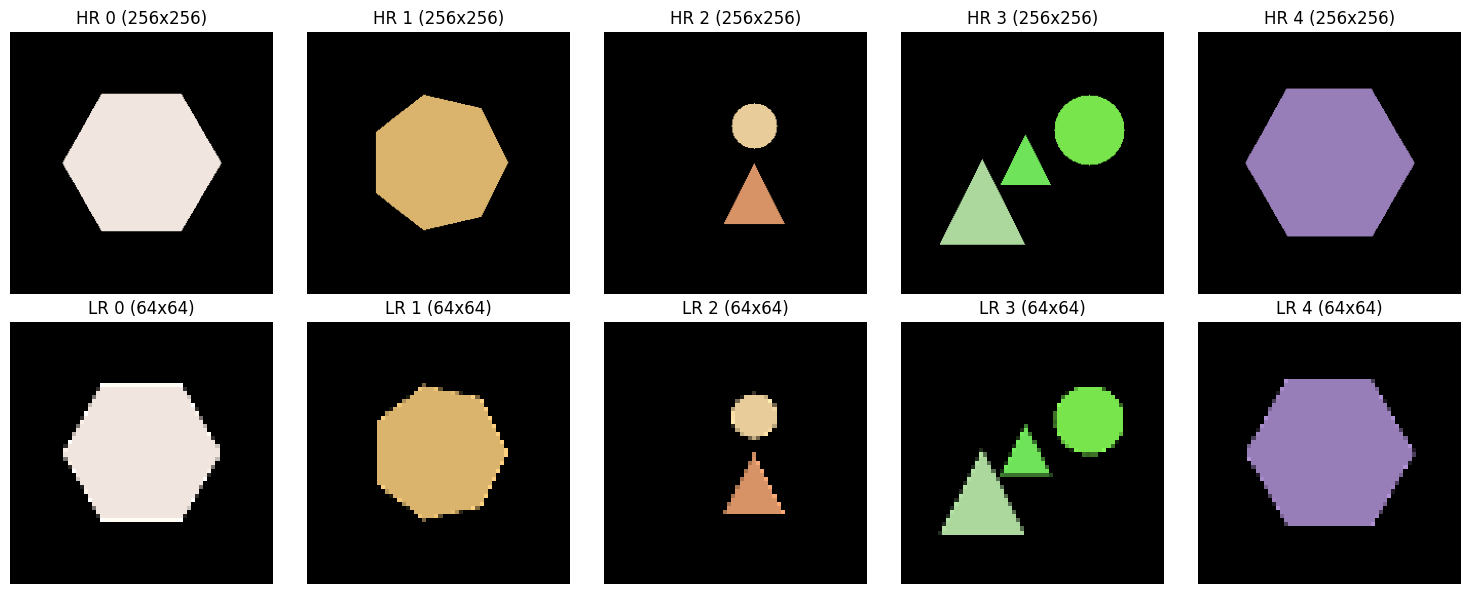

样本可视化已保存: dataset/sample_visualization.png


In [18]:
# 可视化样本
num_display = 5
fig, axes = plt.subplots(2, num_display, figsize=(15, 6))

for i in range(num_display):
    # 读取高分辨率图片
    hr_img = cv2.imread(str(hr_dir / f'hr_{i:05d}.png'))
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
    
    # 读取低分辨率图片
    lr_img = cv2.imread(str(lr_dir / f'lr_{i:05d}.png'))
    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
    
    # 显示高分辨率
    axes[0, i].imshow(hr_img)
    axes[0, i].set_title(f'HR {i} ({HR_SIZE}x{HR_SIZE})')
    axes[0, i].axis('off')
    
    # 显示低分辨率
    axes[1, i].imshow(lr_img)
    axes[1, i].set_title(f'LR {i} ({LR_SIZE}x{LR_SIZE})')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(dataset_dir / 'sample_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"样本可视化已保存: {dataset_dir / 'sample_visualization.png'}")

In [19]:
# 数据集统计信息
print("\n=== 数据集统计 ===")
print(f"总样本数: {NUM_SAMPLES}")
print(f"高分辨率尺寸: {HR_SIZE}x{HR_SIZE}")
print(f"低分辨率尺寸: {LR_SIZE}x{LR_SIZE}")
print(f"缩放倍数: {SCALE_FACTOR}x")
print(f"\n形状类型: 圆形、矩形、三角形、椭圆、多边形、组合形状")

# 计算数据集大小
import os
hr_size_mb = sum(os.path.getsize(hr_dir / f) for f in os.listdir(hr_dir)) / (1024 * 1024)
lr_size_mb = sum(os.path.getsize(lr_dir / f) for f in os.listdir(lr_dir)) / (1024 * 1024)

print(f"\n高分辨率数据集大小: {hr_size_mb:.2f} MB")
print(f"低分辨率数据集大小: {lr_size_mb:.2f} MB")
print(f"总大小: {hr_size_mb + lr_size_mb:.2f} MB")


=== 数据集统计 ===
总样本数: 1000
高分辨率尺寸: 256x256
低分辨率尺寸: 64x64
缩放倍数: 4x

形状类型: 圆形、矩形、三角形、椭圆、多边形、组合形状

高分辨率数据集大小: 1.54 MB
低分辨率数据集大小: 0.63 MB
总大小: 2.17 MB
